# Stock Prediction
### Ignacio Fernández Adrados

---

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Input, LSTM, Dropout # type: ignore
from keras.optimizers import RMSprop # type: ignore
from keras.callbacks import Callback # type: ignore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.client import device_lib

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14620518285604834035
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10204843420551507964
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [29]:
import requests # type: ignore
import pandas as pd
import io

#FILE='AMAZON.csv'
#file=pd.read_csv(FILE, sep=';').loc[::-1].reset_index(drop=True)

APIKEY='X9WT0QP6QJUP62Z2'
DATES = ['2023-02']
#file = pd.DataFrame
file=None
for date in DATES:
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey='
    url += APIKEY+'&datatype=csv&month=' + date
    r = requests.get(url)
    file = pd.concat([file, pd.read_csv(io.StringIO(r.content.decode('utf-8')))])
    print(file.shape)
file.head()

(2, 1)


,{
0,"""Information"": ""Thank you for using Alpha ..."
1,}


In [8]:
N=60     #Minutos agrupados
DATEFILTER='' #Filtro de fecha


df = file[file['Date'].str.startswith(DATEFILTER)]
df=pd.DataFrame(df)
df=df.drop(columns=["Date"])
dfgroup=pd.DataFrame(df['open'].groupby(df.index//N).first())
dfgroup=dfgroup.join(pd.DataFrame(df['close'].groupby(df.index//N).last()))
dfgroup=dfgroup.join(pd.DataFrame(df['low'].groupby(df.index//N).min()))
dfgroup=dfgroup.join(pd.DataFrame(df['high'].groupby(df.index//N).max()))
dfgroup=dfgroup.join(pd.DataFrame(df['volume'].groupby(df.index//N).sum()))
dfgroup = dfgroup.reset_index(drop=True)
dfgroup.info()

NameError: name 'file' is not defined

In [ ]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

dfgroup['EMA7']= dfgroup['close'].ewm(span=7, adjust=False).mean()
dfgroup['MACD']= dfgroup['close'].ewm(span=12, adjust=False).mean()- dfgroup['close'].ewm(span=26, adjust=False).mean()
dfgroup['SignalMACD'] = dfgroup['MACD'].ewm(span=9, adjust=False).mean()
dfgroup['RSI'] = get_rsi(dfgroup['close'], 14)
dfgroup = dfgroup.dropna()
dfgroup = dfgroup.reset_index(drop=True)
dfgroup.head()

,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI
0,150.3000,150.5700,150.10,152.935,233050,151.216055,-0.300307,-0.112796,12.310729
1,150.5700,149.6900,148.86,152.380,9796372,150.834541,-0.423217,-0.174880,8.044607
2,149.6900,149.0400,148.39,149.819,5621409,150.385906,-0.566543,-0.253213,6.306259
3,149.0400,150.8321,148.98,150.930,5470169,150.497454,-0.529419,-0.308454,42.925408
4,150.8321,149.5900,149.59,150.950,3158193,150.270591,-0.593386,-0.365441,33.231021


In [ ]:
#Normalise data into (0,1) range
normData=dfgroup
scaler = MinMaxScaler(feature_range=(0, 1))
#normData[['open']] = scaler.fit_transform(normData[['open']])
normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']] = scaler.fit_transform(normData[['open','close','low','high','volume','EMA7','MACD','SignalMACD','RSI']])
normData.head()

,open,close,low,high,volume,EMA7,MACD,SignalMACD,RSI
0,0.116052,0.120933,0.490600,0.103362,0.004429,0.125855,0.284342,0.308448,0.074238
1,0.120933,0.105025,0.477503,0.096757,0.190133,0.118803,0.261885,0.295699,0.021493
2,0.105025,0.093275,0.472539,0.066278,0.109062,0.110509,0.235698,0.279613,0.000000
3,0.093275,0.125671,0.478771,0.079500,0.106125,0.112571,0.242481,0.268270,0.452751
4,0.125671,0.103218,0.485213,0.079738,0.061231,0.108378,0.230794,0.256567,0.332892


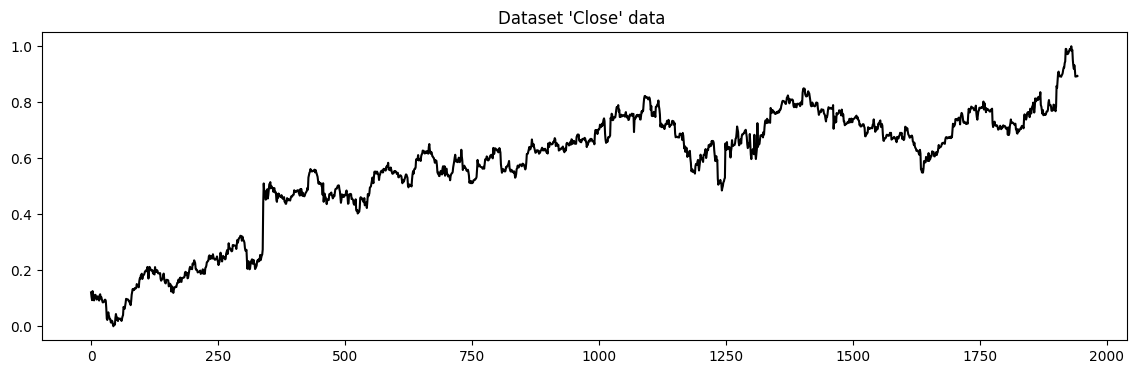

In [ ]:
plt.figure(figsize=(14,4))
plt.title("Dataset 'Close' data ")
plt.plot(normData['close'],color='black')
#plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red", marker="v")
#plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing.

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [ ]:
S=0.7
step = 5

split = int(len(normData) * S)
#values = normData.values
#print(values)
train = normData[:split]#.drop(['buysell'],axis=1)
test = pd.concat([train.tail(step),normData[split:]]).reset_index(drop=True)

print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (1360, 9)
Test data length: (588, 9)


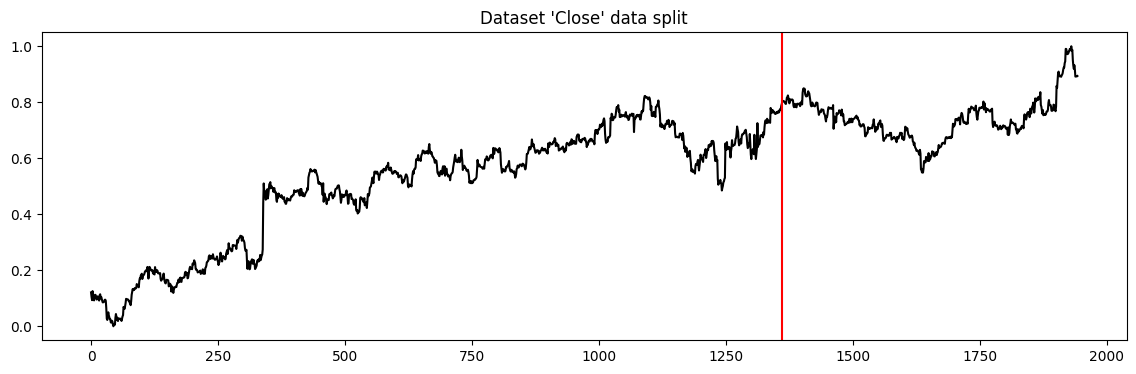

In [ ]:
plt.figure(figsize=(14,4))
plt.title("Dataset 'Close' data split")
plt.plot(normData.index.values,normData['close'],c='black')
plt.axvline(normData.index[split], c="r")
#plt.scatter(normData.index, np.where(normData['buysell'] == -1,normData['close'], None), color="red",  marker="v")
#plt.scatter(normData.index, np.where(normData['buysell'] ==  1,normData['close'], None), color="blue", marker="^")
plt.show()


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [ ]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        #print(i, d, data[i:d)
        X.append(data[i:d])
        Y.append(data[d,1])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train.to_numpy(),step)
testX,testY =convertToMatrix(test.to_numpy(),step)
#print(trainY)
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)


Training data shape: (1355, 5, 9) ,  (1355,)
Test data shape: (583, 5, 9) ,  (583,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [ ]:
UNITS = 500 #num_units: Number of units of a the simple RNN layer
DENSEUNITS = 32 #Number of neurons in the dense layer followed by the RNN layer
LR = 0.001 #Learning rate (uses RMSprop optimizer)

model = Sequential()
model.add(Input((step, trainX.shape[2])))
model.add(LSTM(units=UNITS, activation="tanh",return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=UNITS//2, activation="tanh"))
model.add(Dropout(0.2))
#model.add(SimpleRNN(units=UNITS//3, activation="relu"))
model.add(Dense(DENSEUNITS, activation="tanh"))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer=RMSprop(LR),metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 500)              │       1,020,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 250)                 │         751,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           8,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,779,065 (6.79 MB)

 Trainable params: 1,779,065 (6.79 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the model

In [ ]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        #if (epoch+1) % 10 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

batch_size=64
num_epochs = 5

model.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

Epoch number 1 done
Epoch number 2 done
Epoch number 3 done
Epoch number 4 done
Epoch number 5 done


### Plot loss

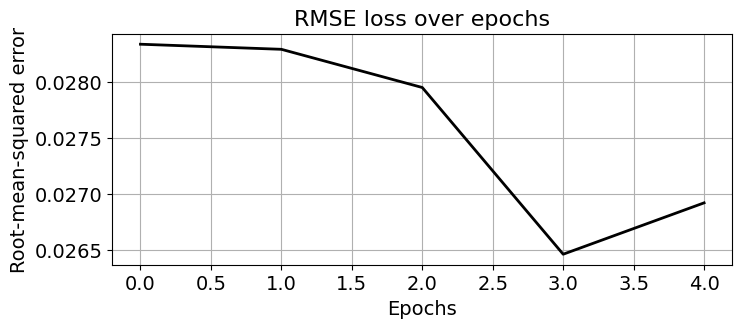

In [ ]:
plt.figure(figsize=(8,3))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data.

In [ ]:
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
print(trainPredict.shape)
print(testPredict.shape)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(1355, 1)
(583, 1)


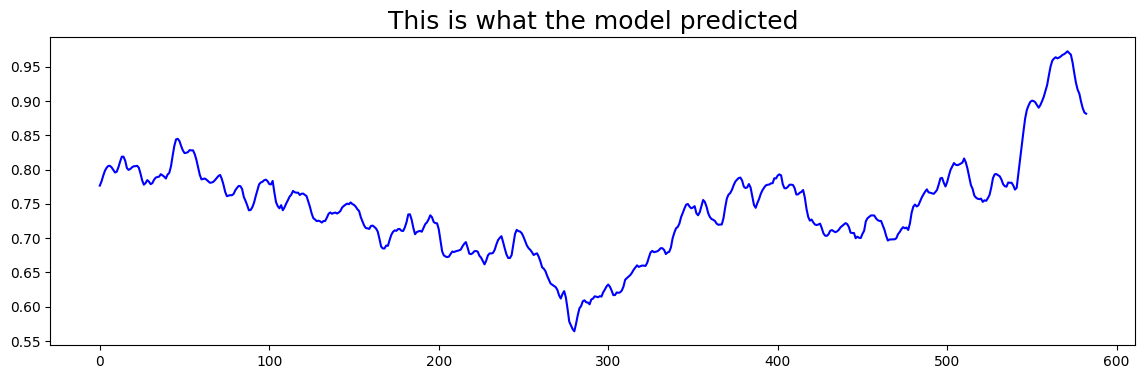

In [ ]:
plt.figure(figsize=(14,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,color='blue')
plt.show()

### Comparing it with the ground truth (test set)

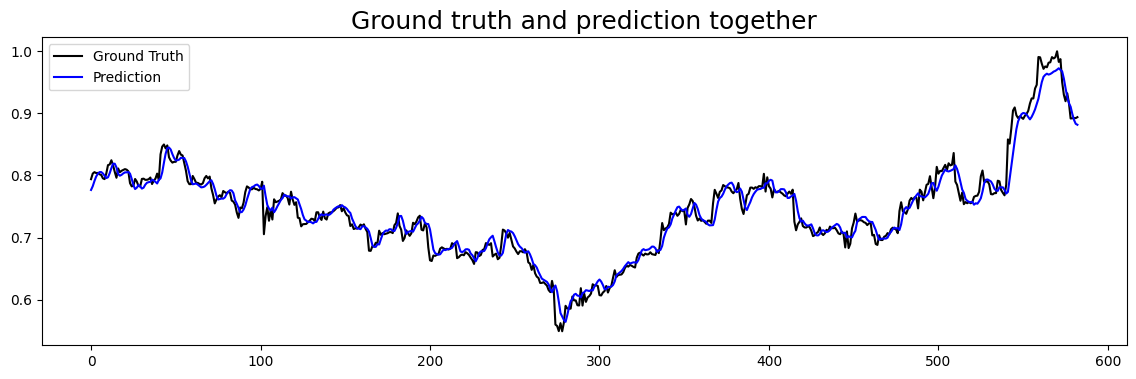

In [ ]:
OFFSET=0

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black', label='Ground Truth')
plt.plot(testPredict[OFFSET:],color='blue', label='Prediction')
plt.legend()
plt.show()

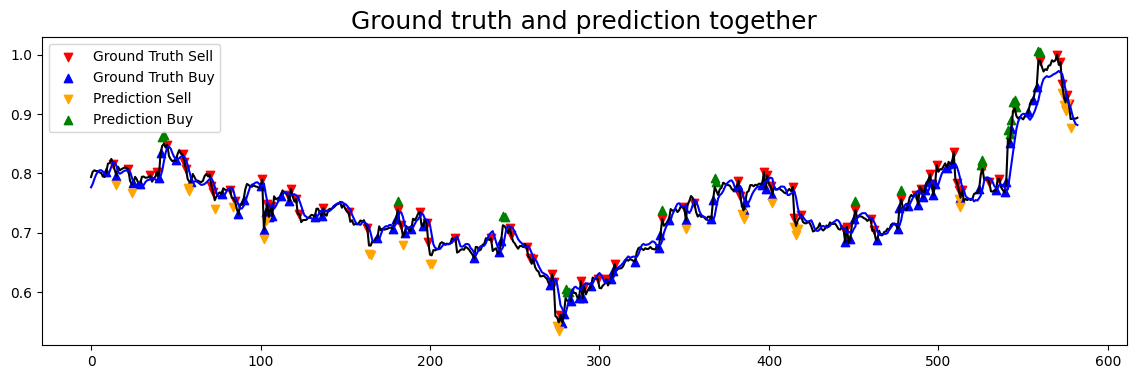

In [ ]:
PROFIT=0.01
OFFSET=0

decision=test['close'].iloc[step:]
decision = decision.diff()
decision = decision.dropna()
decision = np.where(abs(decision)<PROFIT,0,np.sign(decision).astype('int'))
decision = pd.DataFrame(data={'buysell':decision})#.drop(0).reset_index(drop=True)

predictedDecision = pd.DataFrame(data={'buysellPredicted':testPredict[:,0]})
predictedDecision = predictedDecision.diff()
predictedDecision = predictedDecision.dropna()#.reset_index(drop=True)
predictedDecision = np.where(abs(predictedDecision)<PROFIT,0,np.sign(predictedDecision).astype('int'))
predictedDecision = pd.DataFrame(data={'buysellPredicted':predictedDecision[:,0]})

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')
plt.plot(testPredict[OFFSET:],color='blue')

x = decision.iloc[OFFSET:].reset_index(drop=True).index
y = normData['close'].iloc[len(normData)-len(predictedDecision.index)-1+OFFSET:-1].reset_index(drop=True)

plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] == -1,y, None), color="red",  marker="v", label='Ground Truth Sell')
plt.scatter(x, np.where(decision['buysell'].iloc[OFFSET:] ==  1,y, None), color="blue", marker="^", label='Ground Truth Buy')

plt.scatter(x, np.where(predictedDecision['buysellPredicted'].iloc[OFFSET:] == -1,y-0.015, None), color="orange",  marker="v", label='Prediction Sell')
plt.scatter(x, np.where(predictedDecision['buysellPredicted'].iloc[OFFSET:] ==  1,y+0.015, None), color="green",  marker="^", label='Prediction Buy')
plt.legend()
plt.show()

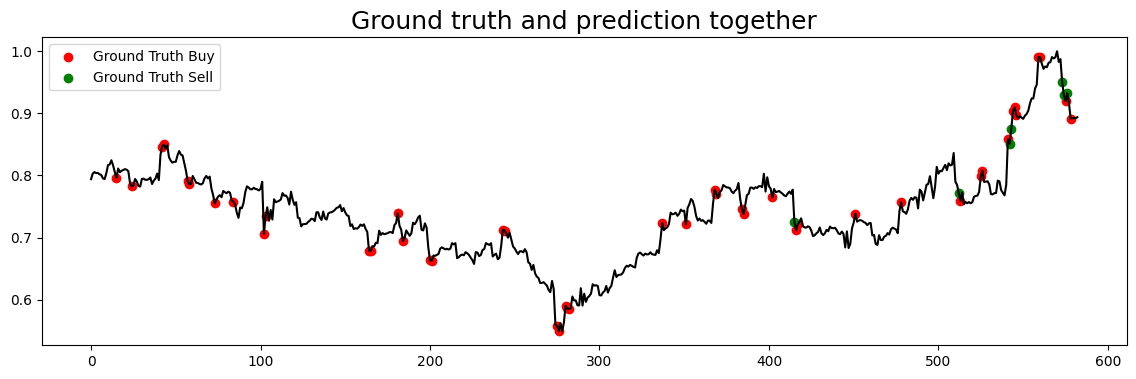

In [ ]:
OFFSET=0

index = normData.index.values
plt.figure(figsize=(14,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(normData['close'].iloc[split+OFFSET:].reset_index(drop=True),color='black')
#plt.plot(testPredict[OFFSET:],color='blue')

x = decision.iloc[OFFSET:].reset_index(drop=True).index
y = normData['close'].iloc[len(normData)-len(predictedDecision.index)-1+OFFSET:-1].reset_index(drop=True)

plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] !=  predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (predictedDecision['buysellPredicted'].iloc[OFFSET:] != 0),y, None), color="red", label='Ground Truth Buy')
plt.scatter(x, np.where((decision['buysell'].iloc[OFFSET:] == predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysell'].iloc[OFFSET:] != 0),y, None), color="green",  label='Ground Truth Sell')

plt.legend()
plt.show()

In [ ]:
print("Predicciones no coincidentes con el conjunto de pruebas: ", np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] !=  predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (predictedDecision['buysellPredicted'].iloc[OFFSET:] != 0),y, None)))
print("Predicciones coincidentes con el conjunto de pruebas: ", np.count_nonzero(np.where((decision['buysell'].iloc[OFFSET:] == predictedDecision['buysellPredicted'].iloc[OFFSET:]) & (decision['buysell'].iloc[OFFSET:] != 0),y, None)))

Predicciones no coincidentes con el conjunto de pruebas:  45
Predicciones coincidentes con el conjunto de pruebas:  7


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
from datasets import load_dataset

ds = load_dataset("sehyun66/Finnhub-News", "clean")

In [ ]:
import pandas as pd

pdds = pd.DataFrame(ds['clean'])
pdds = pdds.drop(columns=['image','source','url','id'])
pdds

In [ ]:
pdds['datetime'] =pd.to_datetime(pdds['datetime'], unit='ms')
pdds

In [ ]:
aapl = pdds[pdds['related'].str.contains('|'.join(['AAPL', 'GOOGL','AMZN']))]
#aapl.dropna(axis=0, how='any')
aapl = aapl.drop(aapl[aapl['summary']==''].index)
aapl = aapl.drop(aapl[aapl['headline']==''].index)
aapl



In [ ]:
import numpy as np

headlines_array = np.array(aapl)
i=0
rango = 100
inputsArray =[]

while len(headlines_array) > i*rango:
    headlines_list = list(headlines_array[i*rango:(i+1)*rango, 4])
    inputsArray.append(tokenizer(headlines_list, padding = True, truncation = True, return_tensors='pt'))
    i = i + 1

In [ ]:
import torch

positive = []
negative = []
neutral = []

for inputs in inputsArray:
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    positive.extend(predictions[:, 0].tolist())
    negative.extend(predictions[:, 1].tolist())
    neutral.extend(predictions[:, 2].tolist())


In [ ]:
model.config.id2label

table = {'Date':headlines_array[:,0],
         'Headline':headlines_array[:,4],
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
      
df = pd.DataFrame(table, columns = ["Date","Headline", "Positive", "Negative", "Neutral"])
df = df.sort_values("Date")
df
